In [1]:
# %pip install -U qiskit
# %pip install -U pandas
from qiskit import __version__
print('Qiskit Sürümü: ', __version__)

Qiskit Sürümü:  1.0.2


## <b> Shor Algoritması </b>

In [13]:
import numpy as np
import pandas as pd
from fractions import Fraction
from math import gcd

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import quantum_info
from qiskit.visualization import plot_bloch_multivector

<b style="color:crimson;">Not:</b> Bu örnek 15 sayısı için geçerli bir devre oluşturmaktadır. Farklı sayılar için farklı devreler oluşturulması gerekir. 
<br>Fakat <b>a</b> değeri $a\in[2, 7, 8, 11, 13]$ seçilebilir.

In [3]:
a = 7
N = 15

# 15 için 4 kubite ihtiyaç var (15='1111'). 2*4=8 adet kübit gerekir.
n_count = 8  # Sayma kubit sayısı

## Kuantum devre üzerinde $a \textrm{ mod } 15$ işlemini yapan devre

In [4]:
def c_amod15(a, power):
    """ Kontrollü a%15 kapısı"""
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' şu degerleri alabilir: 2, 7, 8, 11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    # Devreye isim verilebilir.
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

### Bulunan periyotu hesaplama bazına döndürmek için ters QFT kullanılması gerek

In [5]:
def qft_dagger(n):
    """ ters QFT """
    
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

### Shor için kuantum devresi hazırlama

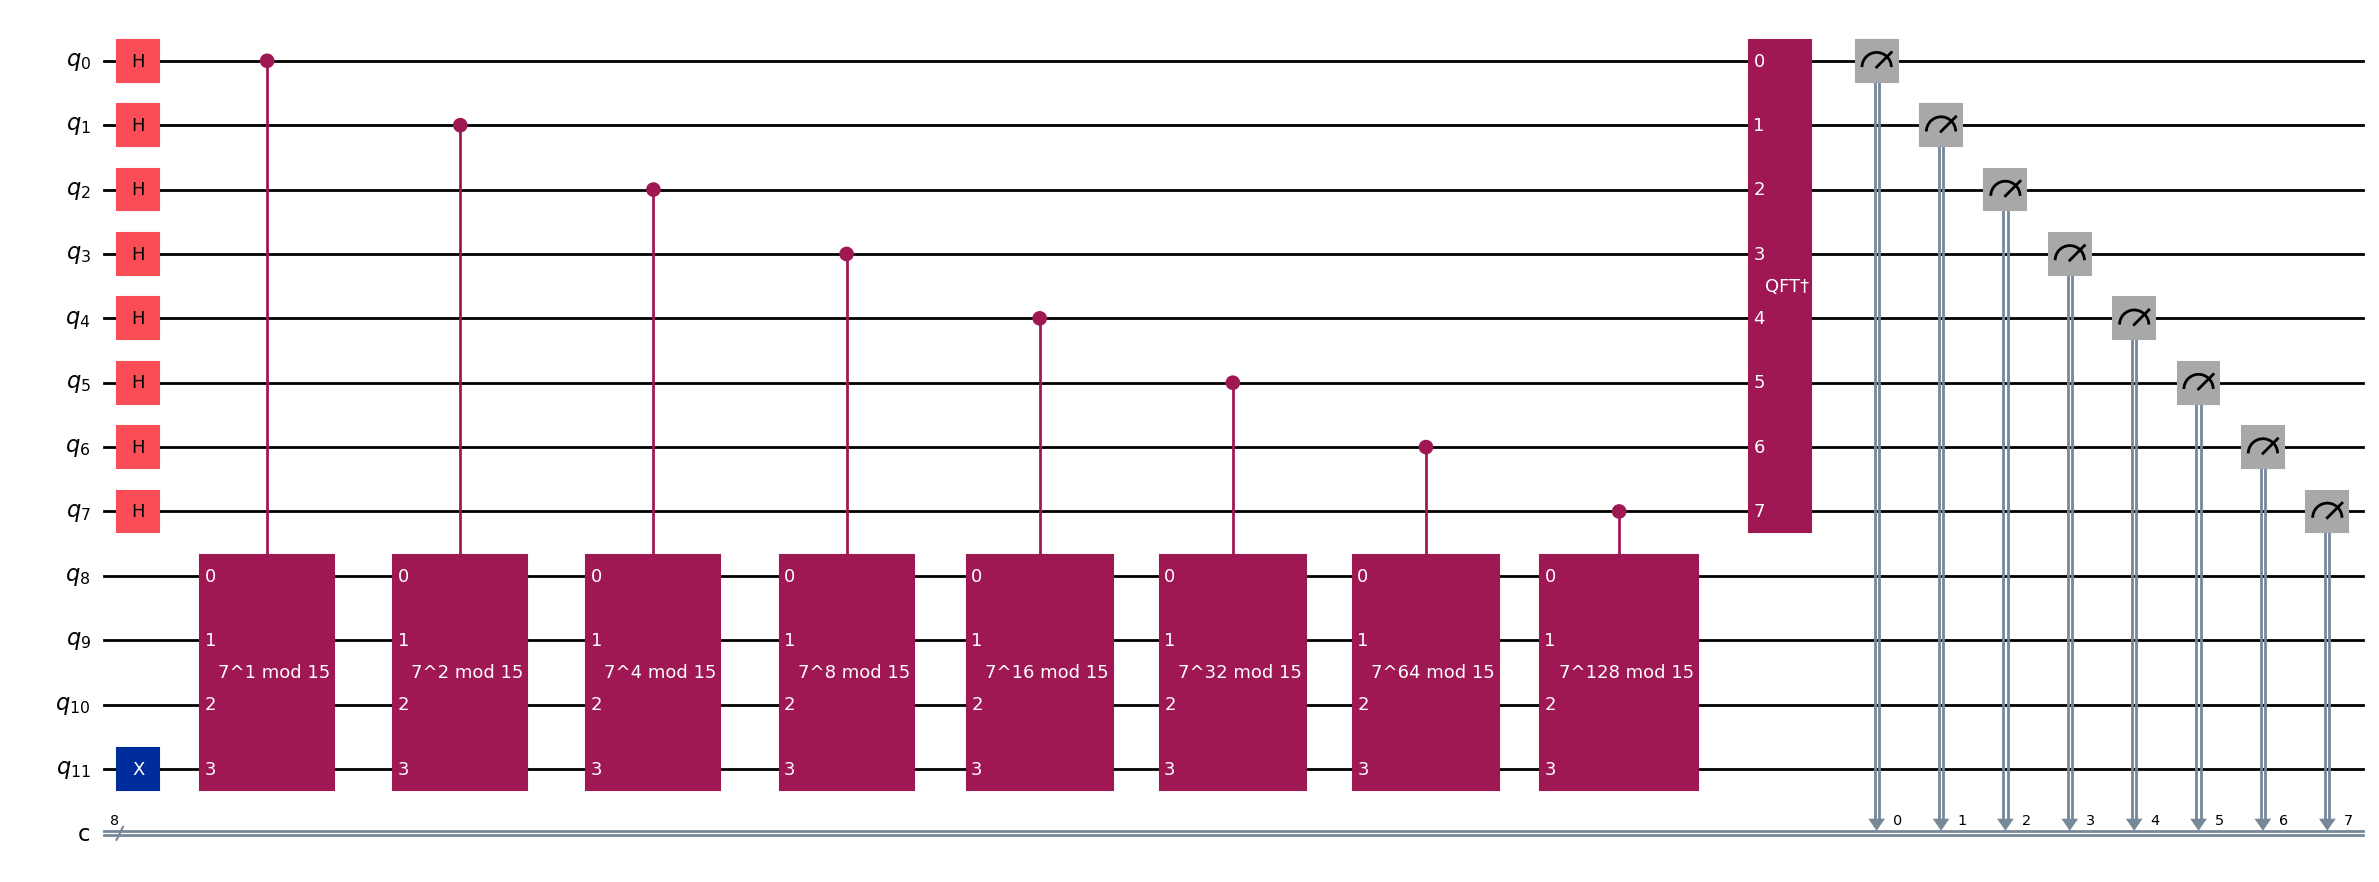

In [6]:
shor_circuit = QuantumCircuit(n_count + 4, n_count)

for q in range(n_count):
    shor_circuit.h(q)
    
# Bir adet anchilla kübitimizi |1> yapılır.
shor_circuit.x(3+n_count)

# Kontrollü a%15 kapılarını ekleme.
for q in range(n_count):
    shor_circuit.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Kuantum ters QFT eklenir.
shor_circuit.append(qft_dagger(n_count), range(n_count))

# Ölçüm eklenir.
shor_circuit.measure(range(n_count), range(n_count))
shor_circuit.draw(output='mpl', fold=-1)

### Devrenin simüle edilmesi

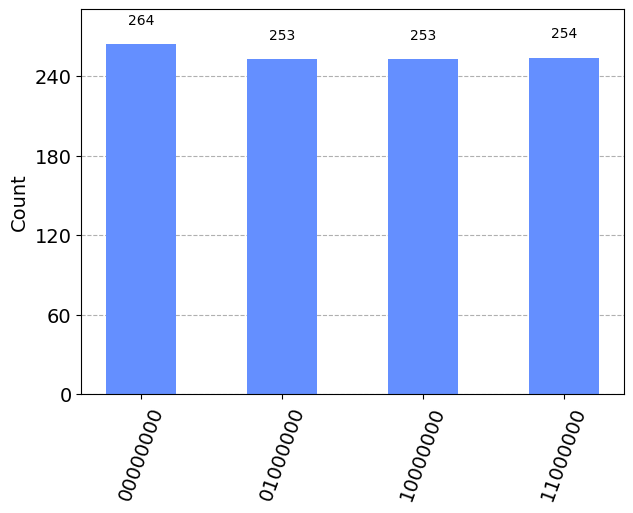

In [7]:
simulator = AerSimulator()
shor_circuit = transpile(shor_circuit, simulator)
counts = simulator.run(shor_circuit).result().get_counts(0)
plot_histogram(counts)

### Ölçüm sonuçlarından klasik olarak periyotun değeri hesaplanmalı 

In [8]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


### Bulunan periyotlardan bir tahmin yapılır

In [11]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.50      1/2            2
2   0.25      1/4            4
3   0.00      0/1            1


### Tahminin EKOK ve EBOB değerleri sayının çarpanlarını ifade eder

In [14]:
r = 4
N = 15
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]
